# Keyness analysis per Genre

In [2]:
# This reload library is just used for developing the notebook
# code and can be removed once this is stable.
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.topic_summary import ModelAnalyser, NurGenreMapper, ReviewExtractor

/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/marijnkoolen/.local/share/virtualenvs/fuzzy-search-KYi4BGOl/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users

### Set paths and load functions

In [4]:
# please adjust the following paths to reflect the location of the following files in your local directory

impact_file = '../data/review-impact_matches.tsv.gz'
raw_review_data = '../data/reviews-stats.tsv.gz'
isbn_map = "../data/work-isbn-mapping.tsv"
isbn_work_id_mappings_file = "../data/work_isbn_title_genre.tsv.gz"

In [5]:
from impfic_core.map.map_genre import read_genre_file

# read review metadata
review_stats = pd.read_csv(raw_review_data, sep='\t', compression='gzip')

# read work genre mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)

# merge review metadata and genre data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# review professional reviews
review_stats = review_stats[review_stats.source != 'NBD_Biblion']


In [6]:
review_stats['nur_genre'] = review_stats.nur_genre.apply(lambda x: 'unknown' if pd.isna(x) else x)


### Review Statistics

In [7]:
print('number of reviews:', len(review_stats))
review_stats.nur_genre.value_counts() / len(review_stats)

number of reviews: 634614


Literary_fiction      0.305584
Non-fiction           0.149828
unknown               0.142777
Literary_thriller     0.119334
Suspense              0.104566
Other fiction         0.054745
Young_adult           0.045815
Children_fiction      0.039511
Fantasy_fiction       0.020644
Romanticism           0.009847
Historical_fiction    0.005184
Regional_fiction      0.002165
Name: nur_genre, dtype: float64

### Load custom-made classes from `topic_summary.py`

In [8]:
# this class helps to preprocess the inputs and output a genre mapping file
mapper = NurGenreMapper(isbn_map, isbn_work_id_mappings_file)

# this class produces as output the impact_reviews
extractor = ReviewExtractor(impact_file, raw_review_data)

### Prepare dataset

In [9]:
# get the mapping file which contains `work_id` and `isbn` columns. These are necessary to merge the reviews with the genre information
mapped_df = mapper.process_genre_mapping()

# remove the isbn so each work_id occurs only once
mapped_df = mapped_df[['work_id', 'nur_genre']].drop_duplicates()

# this is our impact reviews dataset:
review_impact = extractor.get_impact_reviews()

# NB. left-join is the best way to merge the files without losing data
review_impact_with_genre = pd.merge(review_impact, mapped_df, on = 'work_id', how = 'left')

Dataset consists of impact terms extracted from the reviews of books by the impact model and scored according to _affect_, _style_, _narrative_ and _reflection_. 

The _reflection_ category is not validated by the manual annotations (see Boot & Koolen 2021), so we remove all _reflection_-only matches from the dataset:

In [10]:
review_impact_with_genre['nur_genre'] = (review_impact_with_genre
                                         .nur_genre
                                         .apply(lambda x: 'unknown' if pd.isna(x) else x))

review_impact_with_genre = (review_impact_with_genre[review_impact_with_genre[['affect', 'style', 'narrative']]
                            .sum(axis=1) > 0]
                            .drop('reflection', axis=1))

In [291]:
dt = review_impact_with_genre.rename(columns={'style': 'stylistic'})
dt['affect'] = abs(dt[impact_types].sum(axis=1) - 2)
dt.head()

,work_id,review_id,affect,stylistic,narrative,impact_term,review_num_words,nur_genre
0,impfic-work-3723,impfic-review-1,1,0,0,fantastisch,185,Young_adult
1,impfic-work-3723,impfic-review-1,0,0,1,fantastisch,185,Young_adult
2,impfic-work-3723,impfic-review-1,0,0,1,spanning,185,Young_adult
3,impfic-work-36913,impfic-review-2,0,1,0,prachtig,185,Literary_fiction
4,impfic-work-31725,impfic-review-3,1,0,0,leuk,217,Children_fiction


In [292]:
dt = dt[dt.review_id.isin(review_stats.review_id)]

In [293]:
# there are 2.09 million impact matches. 
# Check that the DataFrame has the correct shape
dt.shape

(2089576, 8)

In [332]:
dt[impact_types].sum()

affect       731720
stylistic    667672
narrative    690184
dtype: int64

## Impact Term Frequency Distribution

,impact_term_freq,frac
0,1,0.84
1,2,0.13
2,3,0.02
3,4,0.01
4,5,0.00


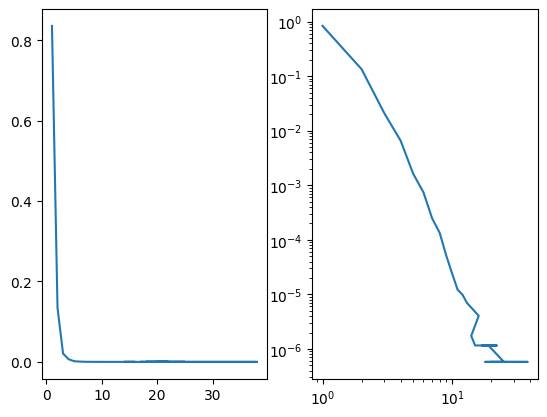

In [294]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

it = 'affect'
#review_impact_freq = dt[dt[it] == 1].groupby('review_id').impact_term.value_counts().rename('freq').reset_index()
impact_freq_dist = review_impact_freq.freq.value_counts() / len(review_impact_freq)
impact_freq_dist.plot(ax=ax[0])
impact_freq_dist.plot(ax=ax[1])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
impact_freq_dist.rename('frac').to_frame().reset_index().rename(columns={'index': 'impact_term_freq'}).head(5).style.format(precision=2)

84% of all impact terms occur only once in a review, a further 13% occurs twice and the remaining 3% of terms occur three or four times. This is a strong signal that impact terms are rarely repeated within a review, and that they are to some extent binary elements. That is, what matters is whether they occur or not (the difference between 0 and 1, or _presence_), not how often (_degree_).

## Compute Document Frequencies

The number of times that an impact terms occurs in a review has an extremely skewed distribution, with the vast majority of reviews having an impact term frequency of 0 or 1. We assume that this is because reviewers only once mention a certain type of impact. As a consequence, occurrence of specific impact terms (with their conditional contexts) is close to a binomial distribution. It either occurs or not. Also, if a certain impact term is mentioned twice or more in a review, it is not clear that it expresses more impact than when it is mentioned once. So we could treat impact as a binary. 

In that case, a simple way to compare the occurrence of impact terms across reviews of different genres is to compute the document frequency $DFreq(t, g)$ per genre (that is, the total number of reviews in a genre $g$ in which an impact term $t$ occurs). Because we have different numbers of reviews per genre, we can make them comparable by normalising document frequency $DFreq$ by the number of reviews to get the document fraction $DFrac(t, g)$. 

### Step 1: Computing Document Frequencies

In [295]:
impact_types = ['affect', 'stylistic', 'narrative']

impact_terms = {it: list(dt[dt[it] == 1].impact_term.unique()) for it in impact_types}

for it in impact_terms:
    print(it, len(impact_terms[it]))

affect 49
stylistic 56
narrative 85


In [333]:

#dt_affect = dt[dt.affect == 1]
impact_doc_freq = {}
for it in impact_types:
    impact_doc_freq[it] = dt[dt[it] == 1][['review_id', 'nur_genre', 'impact_term']].drop_duplicates()
    impact_doc_freq[it]['impact_type'] = it
    impact_doc_freq[it]['occurs'] = 1
    impact_doc_freq[it] = (impact_doc_freq[it].pivot(index=['impact_type', 'nur_genre', 'review_id'], 
                                                     columns='impact_term', 
                                                     values='occurs')
                           .fillna(0.0))
impact_doc_freq['stylistic'].head(5)

impact_term                                        (spreekt|spreken|sprak|spraken).+(me).+(aan)  \
impact_type nur_genre        review_id                                                            
stylistic   Children_fiction impfic-review-100154                                           0.0   
                             impfic-review-100155                                           0.0   
                             impfic-review-100156                                           0.0   
                             impfic-review-100258                                           0.0   
                             impfic-review-100306                                           0.0   

impact_term                                        aangenaam  aantrekkelijk  \
impact_type nur_genre        review_id                                        
stylistic   Children_fiction impfic-review-100154        0.0            0.0   
                             impfic-review-100155        0.0            0.0   
                             impfic-review-100156        0.0            0.0   
                             impfic-review-100258        0.0            0.0   
                             impfic-review-100306        0.0            0.0   

impact_term                                        apart  beschreven  \
impact_type nur_genre        review_id                                 
stylistic   Children_fiction impfic-review-100154    0.0         0.0   
                             impfic-review-100155    0.0         0.0   
                             impfic-review-100156    0.0         1.0   
                             impfic-review-100258    0.0         0.0   
                             impfic-review-100306    0.0         0.0   

impact_term                                        beschrijven  bijzonder  \
impact_type nur_genre        review_id                                      
stylistic   Children_fiction impfic-review-100154          0.0        0.0   
                             impfic-review-100155          0.0        0.0   
                             impfic-review-100156          1.0        0.0   
                             impfic-review-100258          0.0        0.0   
                             impfic-review-100306          0.0        0.0   

impact_term                                        boeien  boeiend  droog  \
impact_type nur_genre        review_id                                      
stylistic   Children_fiction impfic-review-100154     0.0      0.0    0.0   
                             impfic-review-100155     0.0      0.0    0.0   
                             impfic-review-100156     0.0      0.0    0.0   
                             impfic-review-100258     0.0      0.0    0.0   
                             impfic-review-100306     0.0      0.0    0.0   

impact_term                                        ...  prettig  scherp  \
impact_type nur_genre        review_id             ...                    
stylistic   Children_fiction impfic-review-100154  ...      0.0     0.0   
                             impfic-review-100155  ...      0.0     0.0   
                             impfic-review-100156  ...      0.0     0.0   
                             impfic-review-100258  ...      0.0     0.0   
                             impfic-review-100306  ...      0.0     0.0   

impact_term                                        schitterend  schrijfstijl  \
impact_type nur_genre        review_id                                         
stylistic   Children_fiction impfic-review-100154          0.0           1.0   
                             impfic-review-100155          0.0           1.0   
                             impfic-review-100156          0.0           0.0   
                             impfic-review-100258          0.0           0.0   
                             impfic-review-100306          0.0           0.0   

impact_term                                        stijl  subtiel  \
impact_type

In [306]:
genre_impact_doc_freq = {}
for it in impact_types:
    genre_impact_doc_freq[it] = (impact_doc_freq[it]
                                 .reset_index()
                                 .groupby('nur_genre')[impact_terms[it]]
                                 .sum()
                                 .fillna(0.0))

it = 'stylistic'
genre_impact_doc_freq[it]

impact_term,stijl,goed (geschreven|omschreven|beschreven),beschrijven,beschreven,helder,fantastisch,geweldig,omschrijven,taalgebruik,zinnen,...,apart,aantrekkelijk,gelachen,intens,uniek,intrigeren,(spreekt|spreken|sprak|spraken).+(me).+(aan),opmerkelijk,intrigerend,overtuigend
nur_genre,,,,,,,,,,,,,,,,,,,,,
Children_fiction,302.0,486.0,1097.0,896.0,199.0,71.0,174.0,256.0,460.0,716.0,...,16.0,31.0,131.0,8.0,21.0,5.0,9.0,3.0,1.0,0.0
Fantasy_fiction,306.0,507.0,1101.0,918.0,140.0,72.0,125.0,350.0,260.0,336.0,...,28.0,6.0,26.0,17.0,36.0,31.0,3.0,8.0,5.0,0.0
Historical_fiction,60.0,128.0,395.0,339.0,42.0,9.0,27.0,46.0,63.0,100.0,...,1.0,3.0,3.0,6.0,2.0,7.0,3.0,4.0,0.0,0.0
Literary_fiction,7228.0,5516.0,17447.0,14344.0,2554.0,728.0,1520.0,3308.0,4827.0,9497.0,...,366.0,147.0,1167.0,437.0,346.0,418.0,121.0,178.0,64.0,4.0
Literary_thriller,1802.0,3317.0,5644.0,4755.0,843.0,220.0,547.0,1156.0,1140.0,2013.0,...,116.0,42.0,55.0,83.0,97.0,171.0,28.0,37.0,33.0,0.0
Non-fiction,1130.0,1303.0,5225.0,4479.0,4718.0,143.0,356.0,1177.0,659.0,1052.0,...,51.0,64.0,263.0,39.0,84.0,37.0,28.0,30.0,8.0,1.0
Other fiction,969.0,994.0,2840.0,2260.0,894.0,123.0,269.0,586.0,536.0,1006.0,...,46.0,22.0,244.0,69.0,90.0,48.0,13.0,27.0,11.0,1.0
Regional_fiction,24.0,46.0,108.0,91.0,12.0,5.0,3.0,16.0,27.0,24.0,...,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0
Romanticism,123.0,191.0,461.0,377.0,24.0,8.0,42.0,165.0,51.0,104.0,...,4.0,4.0,58.0,8.0,15.0,0.0,3.0,1.0,0.0,0.0


### Step 2: Computing Document Fraction

In [270]:
genre_map_short = {
    'Children_fiction': 'Child. fic',
    'Fantasy_fiction': 'Fantasy',
    'Historical_fiction': 'Hist. fic',
    'Literary_fiction': 'Lit. fic',
    'Literary_thriller': 'Lit. thrill',
    'Non-fiction': 'Non-fic',
    'Other fiction': 'Oth. fic',
    'Regional_fiction': 'Reg. fic',
    'Romanticism': 'Romance',
    'Suspense': 'Suspense',
    'Young_adult': 'YA',
    'unknown': 'Unkn.'
}

genre_map_long = {
    'Children_fiction': "Children's fiction",
    'Fantasy_fiction': 'Fantasy fiction',
    'Historical_fiction': 'Historical fiction',
    'Literary_fiction': 'Literary fiction',
    'Literary_thriller': 'Literary thriller',
    'Non-fiction': 'Non-fiction',
    'Other fiction': 'Other fiction',
    'Regional_fiction': 'Regional fiction',
    'Romanticism': 'Romance',
    'Suspense': 'Suspense',
    'Young_adult': 'YA',
    'unknown': 'Unknown'
}


In [307]:
genre_num_reviews = review_stats.nur_genre.value_counts()
genres = list(genre_num_reviews.index)


genre_impact_doc_frac = {}

for it in impact_types:
    genre_impact_doc_frac[it] = genre_impact_doc_freq[it].T.div(genre_num_reviews)

it = 'stylistic'
genre_impact_doc_frac[it].head(2)

,Children_fiction,Fantasy_fiction,Historical_fiction,Literary_fiction,Literary_thriller,Non-fiction,Other fiction,Regional_fiction,Romanticism,Suspense,Young_adult,unknown
impact_term,,,,,,,,,,,,
stijl,0.012044,0.023357,0.018237,0.037272,0.023795,0.011884,0.027891,0.017467,0.019683,0.025814,0.014996,0.037160
goed (geschreven|omschreven|beschreven),0.019383,0.038699,0.038906,0.028444,0.043800,0.013704,0.028611,0.033479,0.030565,0.040643,0.036595,0.023905


In [308]:
genre_impact_doc_frac['stylistic'].loc['schrijfstijl'].sort_values()

Non-fiction           0.020508
Children_fiction      0.055795
unknown               0.059233
Other fiction         0.074290
Literary_fiction      0.088058
Fantasy_fiction       0.104343
Historical_fiction    0.105775
Literary_thriller     0.118630
Suspense              0.120828
Regional_fiction      0.124454
Young_adult           0.134617
Romanticism           0.145783
Name: schrijfstijl, dtype: float64

In [309]:
genre_impact_doc_frac['stylistic'].loc['schrijfstijl'].to_frame().T
# s = genre_impact_doc_frac['stylistic'].loc['schrijfstijl']

zeta_scores = {
    'impact_type': [],
    'genre1': [],
    'genre2': [],
    'zeta_sum': []
}

fiction_genres = [genre for genre in genres if genre not in {'Non-fiction', 'unknown'}]

for impact_type in impact_types:
    for g1, g2 in permutations(fiction_genres, 2):
        zeta = abs(genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2])
        #zeta = genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2]
        zeta_scores['impact_type'].append(impact_type)
        zeta_scores['genre1'].append(g1)
        zeta_scores['genre2'].append(g2)
        zeta_scores['zeta_sum'].append(zeta.sum())
    

zeta_df = pd.DataFrame(zeta_scores)
zeta_df = zeta_df.pivot(index=['impact_type', 'genre1'], values=['zeta_sum'], columns=['genre2']).fillna(0.0)
(zeta_df.loc['affect']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=2).background_gradient(axis=None))


In [310]:
(zeta_df.loc['narrative']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=2).background_gradient(axis=None))


In [311]:
(zeta_df.loc['stylistic']
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style.format(precision=2).background_gradient(axis=None))


In [312]:
g1 = 'Historical_fiction'
g2 = 'Romanticism'
impact_type = 'stylistic'
(genre_impact_doc_frac[impact_type][g1] - genre_impact_doc_frac[impact_type][g2]).sort_values().head(5)
#sns.scatterplot(x=genre_impact_doc_frac[impact_type][g1], y=genre_impact_doc_frac[impact_type][g2], )

impact_term
humor          -0.091861
luchtig        -0.047083
schrijfstijl   -0.040008
hilarisch      -0.016468
humoristisch   -0.014883
dtype: float64

In [313]:
temp_df = genre_impact_doc_frac[impact_type]
sign_diff = (temp_df[g1] - temp_df[g2])
abs_diff = abs(temp_df[g1] - temp_df[g2])
diff = (pd.concat([temp_df[g1], temp_df[g2], sign_diff, abs_diff], axis=1)
        .rename(columns={0: 'sign_diff', 1: 'abs_diff'})
        .sort_values('sign_diff'))

diff.head(5)

,Historical_fiction,Romanticism,sign_diff,abs_diff
impact_term,,,,
humor,0.018237,0.110098,-0.091861,0.091861
luchtig,0.009726,0.056809,-0.047083,0.047083
schrijfstijl,0.105775,0.145783,-0.040008,0.040008
hilarisch,0.002736,0.019203,-0.016468,0.016468
humoristisch,0.003040,0.017923,-0.014883,0.014883


In [347]:
import matplotlib.pyplot as plt
from adjustText import adjust_text


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


def make_diff(df, impact_type, genre1, genre2):
    sign_diff = (df[impact_type][genre1] - df[impact_type][genre2])
    abs_diff = abs(df[impact_type][genre1] - df[impact_type][genre2])
    diff = (pd.concat([df[impact_type][genre1], df[impact_type][genre2], sign_diff, abs_diff], axis=1)
        .rename(columns={0: 'sign_diff', 1: 'abs_diff'})
        .sort_values('sign_diff'))
    diff['sign'] = diff.sign_diff.apply(lambda x: f'more in {genre_map_long[genre1]}' if x >= 0.0 
                                        else f'more in {genre_map_long[genre2]}')
    return diff


def plot_frac_diff(df, impact_type, genre1, genre2, topn=10):
    diff = make_diff(df, impact_type, genre1, genre2)
    sign_order = [f'more in {genre_map_long[genre1]}', f'more in {genre_map_long[genre2]}']
    top_diff = pd.concat([
        diff.head(topn),
        diff.tail(topn)
    ])
    ax = sns.scatterplot(data=diff, x=genre1, y=genre2, hue='sign', hue_order=sign_order)
    #ax.set_xlim(1,sdf.Freq.max())
    #ax.set_xscale('log')
    ax.set_xlabel(f'Document proportion for genre {genre_map_long[genre1]}')
    ax.set_ylabel(f'Document proportion for genre {genre_map_long[genre2]}')

    num_pos_terms = len(diff[diff.sign_diff > 0.0])
    num_neg_terms = len(diff[diff.sign_diff < 0.0])
    num_neu_terms = len(diff[diff.sign_diff == 0.0])
    
    add_identity(ax, color='gray', linestyle='-')
    
    x = list(top_diff[genre1])
    y = list(top_diff[genre2])
    labels = list(top_diff.index)

    if impact_type == 'stylistic':
        impact_type = 'aesthethic'
    #ax.set_xlabel(f'Impact term frequency of {num_pos_terms} positive and {num_neg_terms} negative keywords')
    ax.set_title(f'{impact_type.title()} impact terms')
    
    texts = [plt.text(x[i], y[i], labels[i]) for i in range(len(x))]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    ax.figure.savefig(f'../images/doc_prop/doc_prop-{impact_type}-{genre1}-{genre2}.png', dpi=150)
    plt.show()



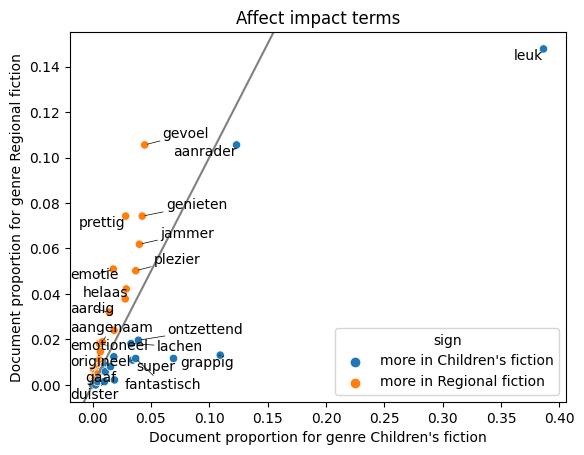

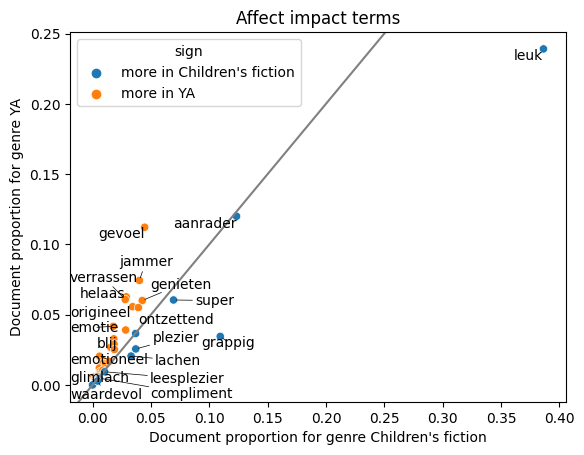

In [348]:
impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Regional_fiction'
plot_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)

impact_type = 'affect'
genre1 = 'Children_fiction'
genre2 = 'Young_adult'
plot_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)


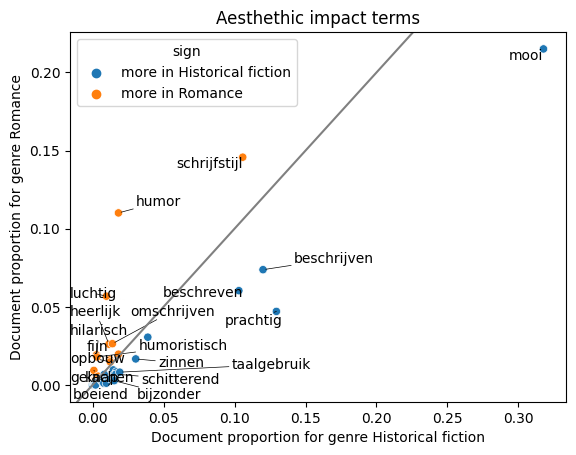

In [349]:
genre1 = 'Historical_fiction'
genre2 = 'Romanticism'
impact_type = 'stylistic'

plot_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)

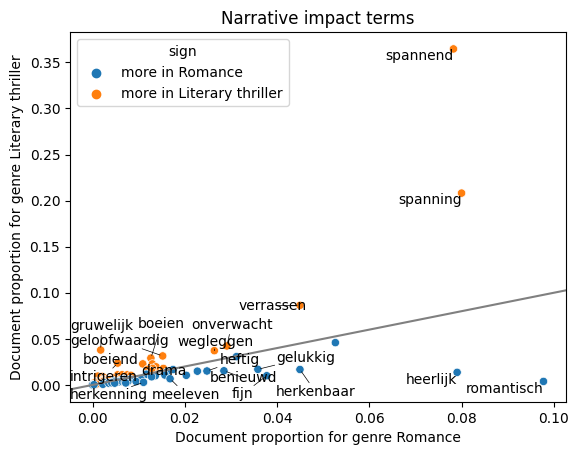

In [345]:
impact_type = 'narrative'
genre1 = 'Romanticism'
genre2 = 'Literary_thriller'
plot_frac_diff(genre_impact_doc_frac, impact_type, genre1, genre2)

(0.0, 0.15)

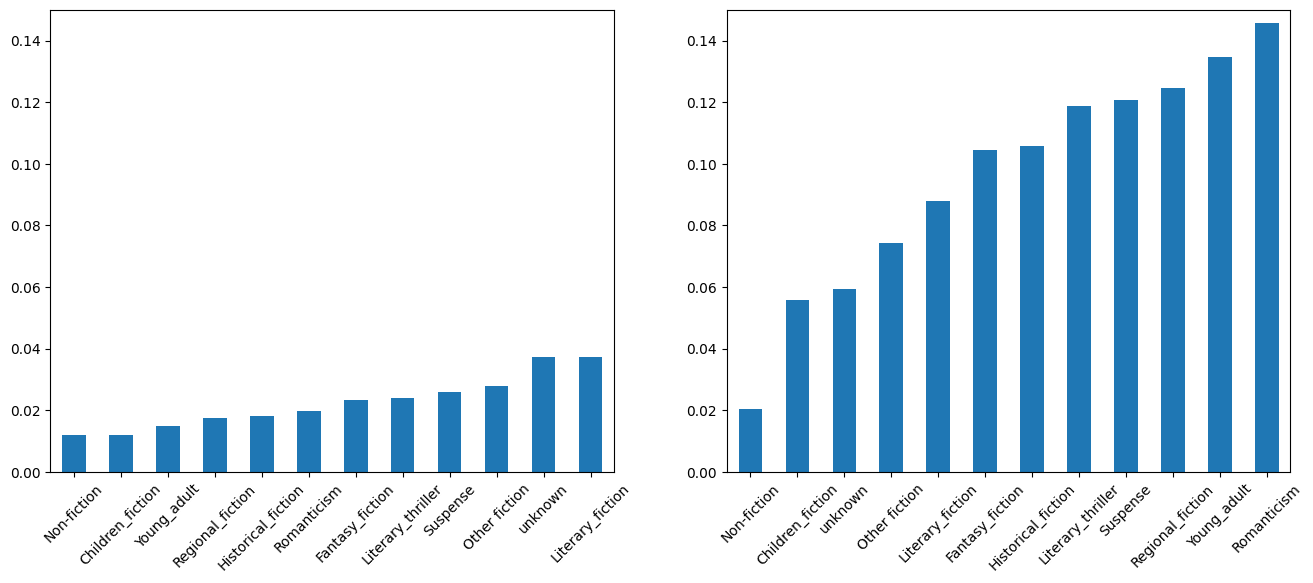

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

genre_impact_doc_frac['stylistic'].loc['stijl'].sort_values().plot(kind='bar', rot=45, ax=ax[0])
genre_impact_doc_frac['stylistic'].loc['schrijfstijl'].sort_values().plot(kind='bar', rot=45, ax=ax[1])
fig.set_size_inches(16, 6)
ax[0].set_ylim(0, 0.15)
ax[1].set_ylim(0, 0.15)


<Axes: >

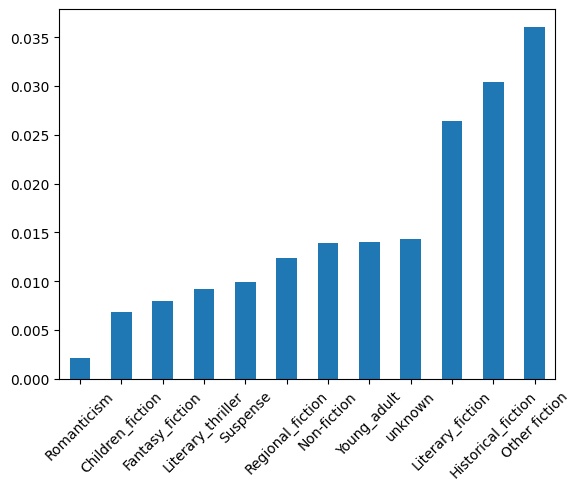

In [85]:
genre_impact_doc_frac['narrative'].loc['indrukwekkend'].sort_values().plot(kind='bar', rot=45)

#### Variation in Document Fractions

(0.0, 0.04088814356076111)

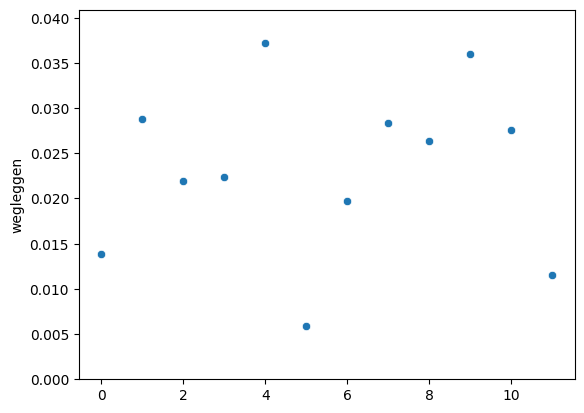

In [40]:
y = genre_impact_doc_frac['affect'].loc['wegleggen']
x = [i for i in range(len(y))]
ax = sns.scatterplot(y=y, x=x)

ax.set_ylim((0,max(y) + 0.1*max(y)))



In [50]:
genre_impact_doc_frac['narrative'].index.sort_values()

Index(['(ik|je) (hoopte|hoopt)', '(ik|je|lezer) (voelt|voelde)',
       '(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit)',
       '(laat|liet|lieten).+(mij|me|je|lezer).+(niet).+(los)',
       '(neem*|nam).+(je|me|lezer|ons).+(mee)',
       '(spreekt|spreken|sprak|spraken).+(me).+(aan)',
       '(zien|ziet|zag).+(voor (me|mij|je))', 'aangrijpend', 'als een trein',
       'apart', 'beklemmend', 'benieuwd', 'boeien', 'boeiend', 'confronteren',
       'drama', 'dramatisch', 'ellende', 'eng', 'fantasie', 'fantastisch',
       'fijn', 'geboeid', 'gegrepen', 'geloofwaardig', 'gelukkig', 'geniaal',
       'geweldig', 'grijpen', 'gruwelijk', 'heerlijk', 'heftig', 'herkenbaar',
       'herkennen', 'herkenning', 'huilen', 'indringend', 'indrukwekkend',
       'inleven', 'intens', 'intrigeren', 'intrigerend', 'krachtig',
       'levendig', 'levensecht', 'mee in', 'meegezogen', 'meeleven',
       'meeslepend', 'mysterieus', 'niet meer stoppen', 'nieuwsgieri

<Axes: xlabel='zucht dicht', ylabel='zucht dicht'>

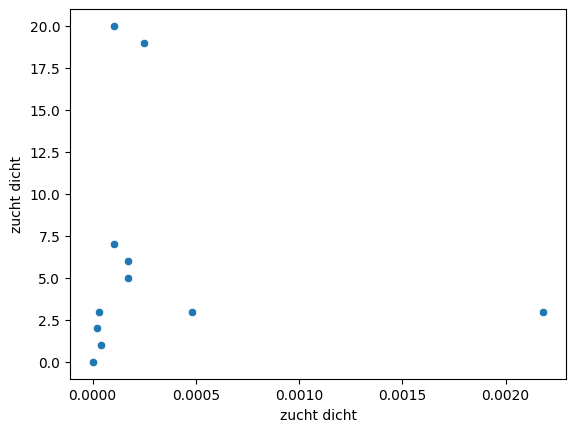

In [49]:
sns.scatterplot(x=genre_impact_doc_frac['affect'].loc['zucht dicht'],
                y=genre_impact_doc_freq['affect'].T.loc['zucht dicht'])


<Axes: xlabel='meeslepend', ylabel='meeslepend'>

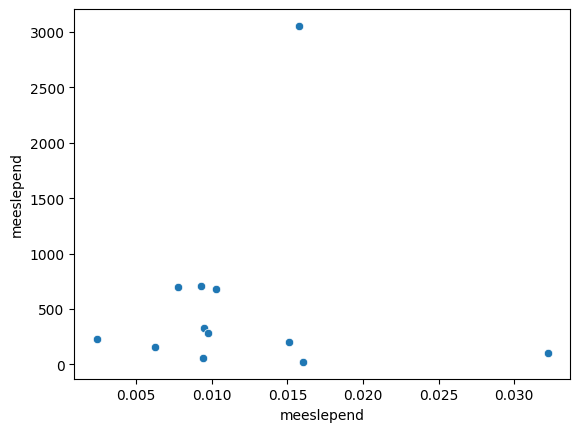

In [51]:
sns.scatterplot(x=genre_impact_doc_frac['narrative'].loc['meeslepend'],
                y=genre_impact_doc_freq['narrative'].T.loc['meeslepend'])


## Comparing Genres

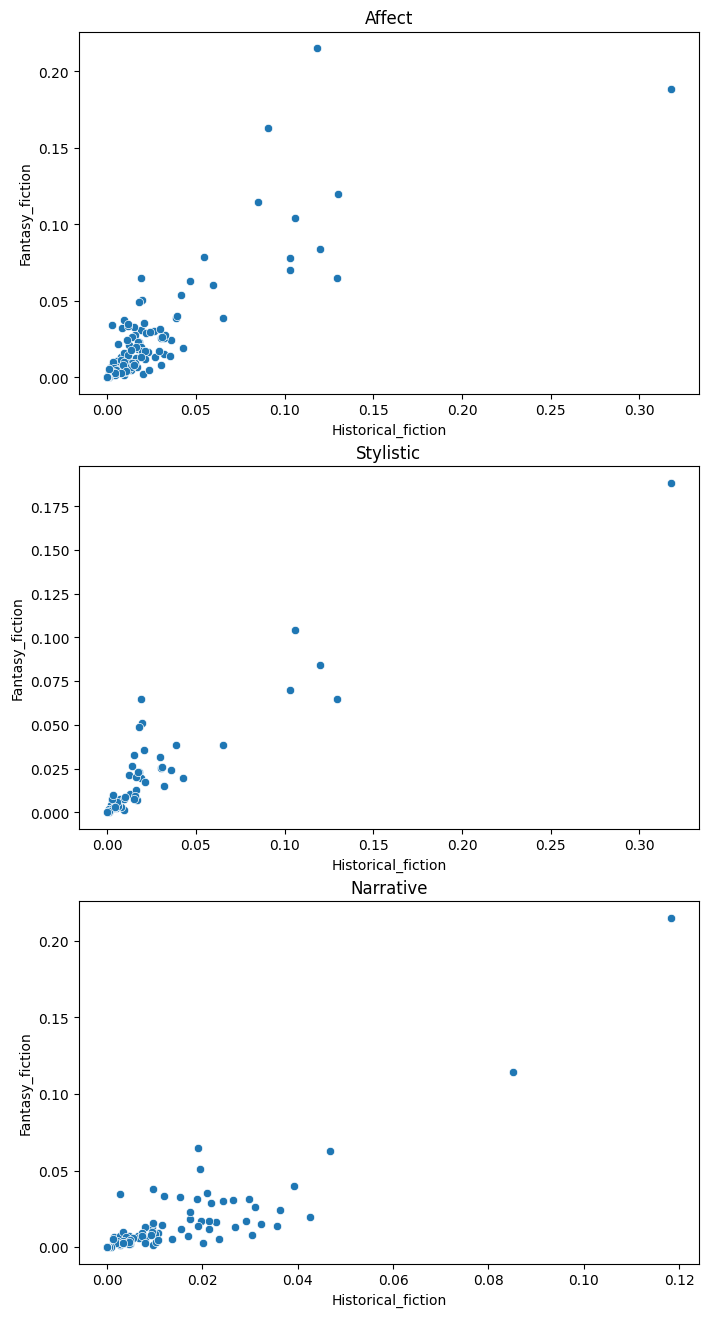

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1)

for i, it in enumerate(impact_types):
    sns.scatterplot(data=genre_impact_doc_frac[it], x='Historical_fiction', y='Fantasy_fiction', ax=ax[i]);
    ax[i].set_title(it.title())

fig.set_size_inches(8,16)

In [70]:


it = 'affect'
(genre_impact_doc_frac[it]
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .corr()
 .style
 .format(precision=2)
 .background_gradient(axis=None))

,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thrill,Non-fic,Oth. fic,Reg. fic,Romance,Suspense,YA,Unkn.
Child. fic,1.00,0.86,0.68,0.73,0.68,0.84,0.82,0.74,0.84,0.69,0.90,0.89
Fantasy,0.86,1.00,0.85,0.84,0.89,0.73,0.84,0.83,0.81,0.89,0.97,0.92
Hist. fic,0.68,0.85,1.00,0.96,0.68,0.77,0.90,0.95,0.75,0.68,0.84,0.91
Lit. fic,0.73,0.84,0.96,1.00,0.63,0.83,0.96,0.95,0.81,0.63,0.85,0.95
Lit. thrill,0.68,0.89,0.68,0.63,1.00,0.43,0.58,0.61,0.57,1.00,0.85,0.72
Non-fic,0.84,0.73,0.77,0.83,0.43,1.00,0.93,0.84,0.83,0.44,0.78,0.89
Oth. fic,0.82,0.84,0.90,0.96,0.58,0.93,1.00,0.95,0.89,0.59,0.87,0.96
Reg. fic,0.74,0.83,0.95,0.95,0.61,0.84,0.95,1.00,0.87,0.61,0.86,0.92
Romance,0.84,0.81,0.75,0.81,0.57,0.83,0.89,0.87,1.00,0.59,0.87,0.87
Suspense,0.69,0.89,0.68,0.63,1.00,0.44,0.59,0.61,0.59,1.00,0.86,0.72


The reason to include non-fiction is that it shows us to what extent impact vocabulary is specific to fiction or not. These correlations show that in terms of _relative frequencies_, literary fiction is very similar to non-fiction ($\rho=0.83$), although it remains to be seen whether in terms of absolute numbers, the percentages are similar.

In [71]:
it = 'narrative'
(genre_impact_doc_frac[it]
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .corr()
 .style
 .format(precision=2)
 .background_gradient(axis=None))

,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thrill,Non-fic,Oth. fic,Reg. fic,Romance,Suspense,YA,Unkn.
Child. fic,1.00,0.94,0.80,0.76,0.92,0.51,0.68,0.67,0.57,0.92,0.95,0.92
Fantasy,0.94,1.00,0.87,0.82,0.95,0.48,0.68,0.70,0.64,0.95,0.98,0.96
Hist. fic,0.80,0.87,1.00,0.90,0.88,0.48,0.78,0.85,0.73,0.88,0.89,0.90
Lit. fic,0.76,0.82,0.90,1.00,0.79,0.73,0.94,0.87,0.72,0.79,0.85,0.92
Lit. thrill,0.92,0.95,0.88,0.79,1.00,0.40,0.64,0.68,0.58,1.00,0.96,0.94
Non-fic,0.51,0.48,0.48,0.73,0.40,1.00,0.88,0.65,0.53,0.39,0.52,0.64
Oth. fic,0.68,0.68,0.78,0.94,0.64,0.88,1.00,0.86,0.71,0.63,0.74,0.82
Reg. fic,0.67,0.70,0.85,0.87,0.68,0.65,0.86,1.00,0.87,0.68,0.75,0.77
Romance,0.57,0.64,0.73,0.72,0.58,0.53,0.71,0.87,1.00,0.59,0.68,0.68
Suspense,0.92,0.95,0.88,0.79,1.00,0.39,0.63,0.68,0.59,1.00,0.96,0.94


In [72]:
it = 'stylistic'
(genre_impact_doc_frac[it]
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .corr()
 .style
 .format(precision=2)
 .background_gradient(axis=None))

,Child. fic,Fantasy,Hist. fic,Lit. fic,Lit. thrill,Non-fic,Oth. fic,Reg. fic,Romance,Suspense,YA,Unkn.
Child. fic,1.00,0.92,0.93,0.96,0.80,0.95,0.97,0.93,0.86,0.79,0.95,0.97
Fantasy,0.92,1.00,0.92,0.94,0.94,0.87,0.94,0.92,0.88,0.94,0.98,0.94
Hist. fic,0.93,0.92,1.00,0.97,0.88,0.94,0.97,0.98,0.83,0.86,0.93,0.96
Lit. fic,0.96,0.94,0.97,1.00,0.87,0.93,0.99,0.95,0.86,0.85,0.94,0.99
Lit. thrill,0.80,0.94,0.88,0.87,1.00,0.76,0.87,0.89,0.85,1.00,0.93,0.86
Non-fic,0.95,0.87,0.94,0.93,0.76,1.00,0.96,0.91,0.78,0.74,0.88,0.95
Oth. fic,0.97,0.94,0.97,0.99,0.87,0.96,1.00,0.96,0.89,0.86,0.95,0.99
Reg. fic,0.93,0.92,0.98,0.95,0.89,0.91,0.96,1.00,0.90,0.88,0.95,0.94
Romance,0.86,0.88,0.83,0.86,0.85,0.78,0.89,0.90,1.00,0.87,0.90,0.85
Suspense,0.79,0.94,0.86,0.85,1.00,0.74,0.86,0.88,0.87,1.00,0.93,0.85


### Min/Max of Document Fractions Between Pairs of Genres

In [73]:
from itertools import combinations, permutations


def compute_min_max(genre_impact_doc_frac):
    genre_sim = []
    
    for genre1, genre2 in permutations(genres, 2):
        s = ((genre_impact_doc_frac[[genre1, genre2]].T.min() / genre_impact_doc_frac[[genre1, genre2]].T.max())
             .fillna(1.0)
             .describe()
             .to_frame().T)
        s['genre1'] = genre1
        s['genre2'] = genre2
        genre_sim.append(s)
        
    genre_sim = pd.concat(genre_sim)
    return (genre_sim
     .set_index(['genre1', 'genre2'])[['mean']]
     .unstack()
     .fillna(1.0)
     .rename(columns={genre: genre_map_short[genre] for genre in genres}))


it = 'affect'
min_max = compute_min_max(genre_impact_doc_frac[it])
min_max.style.format(precision=2).background_gradient(axis=None)

In [74]:
it = 'narrative'
min_max = compute_min_max(genre_impact_doc_frac[it])
min_max.style.format(precision=2).background_gradient(axis=None)

In [75]:
it = 'stylistic'
min_max = compute_min_max(genre_impact_doc_frac[it])
min_max.style.format(precision=2).background_gradient(axis=None)

In [316]:
(genre_impact_df_frac[genre1] - genre_impact_df_frac[genre2]).abs().sum()/2

0.7189836670356508

In [323]:
genre_df_dev = {
    'genre1': [],
    'genre2': [],
    'dev': []
}

for genre1, genre2 in permutations(genres, 2):
    genre_df_dev['genre1'].append(genre1)
    genre_df_dev['genre2'].append(genre2)
    dev = (genre_impact_df_frac[genre1] - genre_impact_df_frac[genre2]).abs().sum() / 2
    genre_df_dev['dev'].append(dev)
    
genre_df_dev = pd.DataFrame(genre_df_dev)
genre_df_dev   
(genre_df_dev
 .set_index(['genre1', 'genre2'])[['dev']]
 .unstack()
 .fillna(1.0)
 .rename(columns={genre: genre_map_short[genre] for genre in genres})
 .style
 .format(precision=2)
 .background_gradient(axis=None))

In [134]:
it = 'affect'
genre_num_terms = []
for it in impact_terms:
    temp = dt[dt[it] == 1].groupby('nur_genre').review_id.count()
    genre_num_terms.append(temp.rename(it))

genre_num_terms = pd.concat(genre_num_terms, axis=1)
genre_num_terms

,affect,stylistic,narrative
nur_genre,,,
Children_fiction,90606,22663,27424
Fantasy_fiction,50855,14101,18297
Historical_fiction,12235,4674,3932
Literary_fiction,658422,257207,195013
Literary_thriller,281879,67394,128003
Non-fiction,206574,71853,36616
Other fiction,116940,40441,33323
Regional_fiction,4588,1635,1335
Romanticism,26699,7604,8143


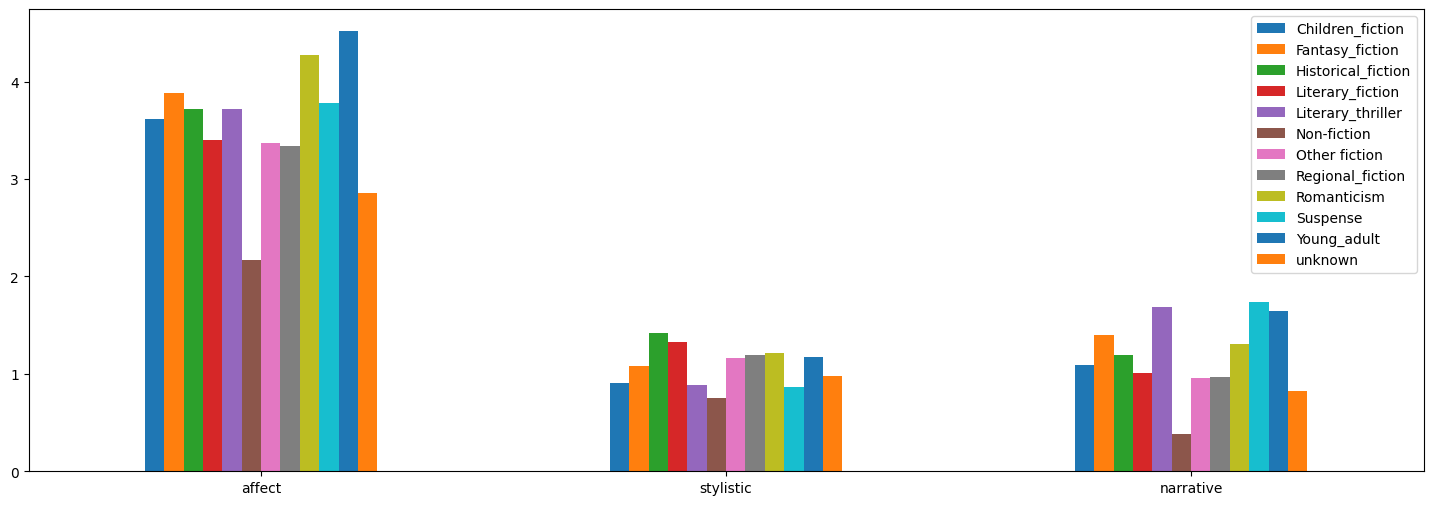

In [131]:
ax = genre_num_terms.T.div(genre_num_reviews).plot(kind='bar', rot=0)
ax.figure.set_size_inches(18, 6)

In [136]:
it = 'affect'
genre_num_terms = []
for it in impact_terms:
    temp = dt[dt[it] == 1].groupby('nur_genre').review_id.nunique()
    genre_num_terms.append(temp.rename(it))

genre_num_impact_reviews = pd.concat(genre_num_terms, axis=1)
genre_num_impact_reviews

,affect,stylistic,narrative
nur_genre,,,
Children_fiction,21379,10497,12641
Fantasy_fiction,10595,5833,7563
Historical_fiction,2787,1968,1836
Literary_fiction,156944,105469,97691
Literary_thriller,64772,31004,53551
Non-fiction,71841,38744,23592
Other fiction,28695,17936,16618
Regional_fiction,1169,734,690
Romanticism,5226,3150,3513


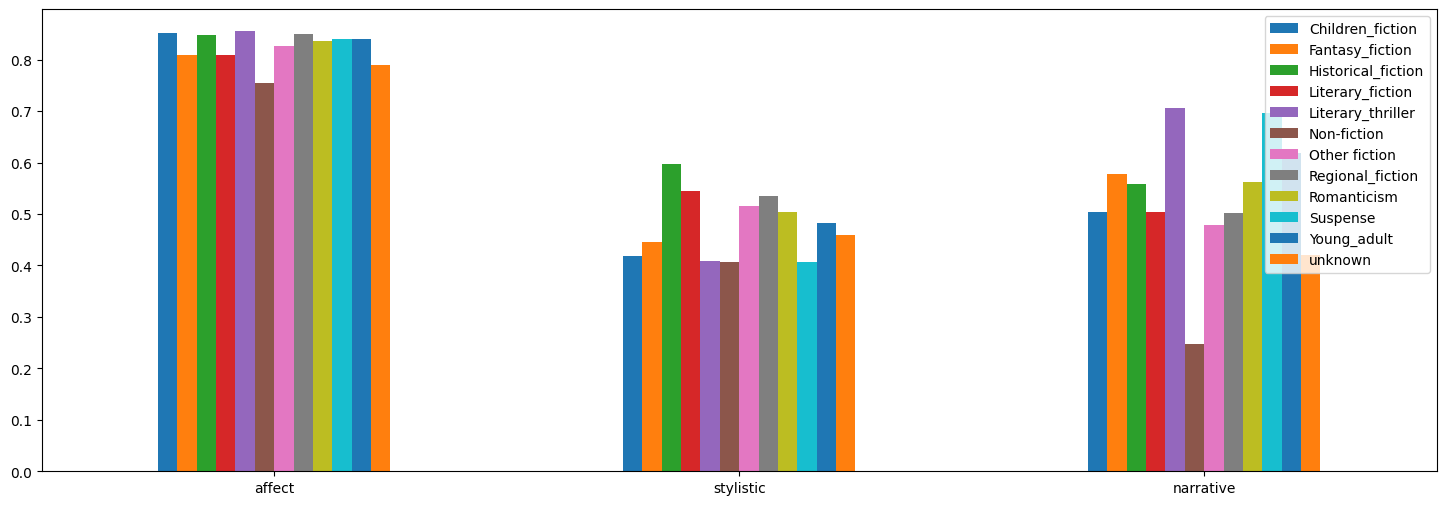

In [137]:
ax = genre_num_impact_reviews.T.div(genre_num_reviews).plot(kind='bar', rot=0)
ax.figure.set_size_inches(18, 6)

## Relation between Impact Terms and Review Length

Do certain impact terms only occur in reviews of a certain length or is it independent of length?

In [189]:
import numpy as np
dt['review_log_length'] = dt.review_num_words.apply(np.log)

In [194]:
#dt.apply(lambda row: 1 if row['stylistic'] == 0 and row['narrative'] == 0 else 0, axis=1)
assert len(dt[dt.affect == 0]) == 0

dt['general'] = abs(dt[impact_types].sum(axis=1) - 2)
temp = (dt.set_index(['review_id', 'review_num_words', 'review_log_length', 'impact_term'])[['general', 'stylistic', 'narrative']]
        .stack().
        rename('occur')
        .reset_index()
        .rename(columns={'level_4': 'impact_type'}))

temp = temp[temp.occur == 1]
temp

,review_id,review_num_words,review_log_length,impact_term,impact_type,occur
2,impfic-review-36635,708,6.562444,onverwacht,narrative,1
4,impfic-review-36635,708,6.562444,stijl,stylistic,1
8,impfic-review-36636,106,4.663439,indrukwekkend,narrative,1
10,impfic-review-36636,106,4.663439,goed (geschreven|omschreven|beschreven),stylistic,1
13,impfic-review-36636,106,4.663439,beschrijven,stylistic,1
...,...,...,...,...,...,...
6268713,impfic-review-671242,122,4.804021,plezier,general,1
6268717,impfic-review-671243,233,5.451038,opbouw,stylistic,1
6268721,impfic-review-671243,233,5.451038,aangrijpend,narrative,1
6268724,impfic-review-671245,69,4.234107,(ik|je|lezer) (voelt|voelde),narrative,1


In [197]:
impact_length_dist = temp.groupby(['impact_type', 'impact_term']).review_num_words.describe()
impact_log_length_dist = temp.groupby(['impact_type', 'impact_term']).review_log_length.describe()
impact_length_dist
impact_log_length_dist

count  \
impact_type impact_term                                                
general     (raakt|raken|raakte|raakten).+(me|mij|je|lezer)   6213.0   
            aangenaam                                        10353.0   
            aanraden                                          9368.0   
            aanrader                                         70317.0   
            aardig                                           13103.0   
...                                                              ...   
stylistic   subtiel                                           5191.0   
            taalgebruik                                      12156.0   
            treffend                                           993.0   
            uniek                                             1042.0   
            zinnen                                           24112.0   

                                                                 mean  \
impact_type impact_term                                                 
general     (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  5.425679   
            aangenaam                                        5.438441   
            aanraden                                         5.033133   
            aanrader                                         4.373642   
            aardig                                           5.064322   
...                                                               ...   
stylistic   subtiel                                          5.719735   
            taalgebruik                                      5.388721   
            treffend                                         5.470029   
            uniek                                            5.592574   
            zinnen                                           5.632196   

                                                                  std  \
impact_type impact_term                                                 
general     (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  0.987457   
            aangenaam                                        1.005285   
            aanraden                                         0.980806   
            aanrader                                         1.034322   
            aardig                                           1.109005   
...                                                               ...   
stylistic   subtiel                                          0.912230   
            taalgebruik                                      1.026318   
            treffend                                         0.988990   
            uniek                                            0.960768   
            zinnen                                           0.967670   

                                                                  min  \
impact_type impact_term                                                 
general     (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  1.609438   
            aangenaam                                        0.693147   
            aanraden                                         1.098612   
            aanrader                                         0.000000   
            aardig                                           0.000000   
...                                                               ...   
stylistic   subtiel                                          1.098612   
            taalgebruik                                      0.693147   
            treffend                                         2.302585   
            uniek                                            1.791759   
            zinnen                                           1.386294   

                                                                  25%  \
impact_type impact_term                                                 
general     (raakt|raken|raakte|raakten).+(me|mij|je|lezer)  4.779123   
            aangenaam                                    

In [202]:
impact_length_dist.loc['stylistic']
impact_log_length_dist.loc['stylistic'].sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
impact_term,,,,,,,,
gelachen,2471.0,4.541475,1.135853,0.693147,3.688879,4.465908,5.459586,7.643483
goed (geschreven|omschreven|beschreven),19030.0,4.668585,1.153333,0.693147,3.806662,4.672829,5.605802,8.985195
geweldig,4392.0,4.721245,1.170392,0.693147,3.828641,4.691348,5.645447,8.161375
pakkend,481.0,4.812796,1.041539,1.945910,4.077537,4.736198,5.659482,8.148735
boeiend,4429.0,4.808384,1.103109,0.693147,4.007333,4.836282,5.710427,8.036897
meeslepend,1520.0,4.897728,1.240568,1.386294,3.988984,4.852030,5.918894,8.110127
fantastisch,2034.0,4.843650,1.170781,1.098612,3.951244,4.859812,5.821562,8.027150
(spreekt|spreken|sprak|spraken).+(me).+(aan),296.0,5.038601,1.049122,2.397895,4.304065,4.882773,5.746978,8.148735
prachtig,64913.0,4.905329,1.194782,0.693147,4.007333,4.990433,5.866468,8.861917


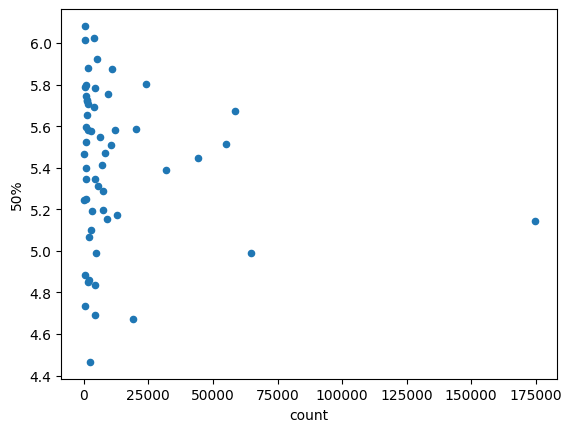

In [199]:
ax = impact_log_length_dist.loc['stylistic'].plot(kind='scatter', x='count', y='50%')
#impact_log_length_dist.loc['stylistic']

In [175]:
impact_length_dist.loc['narrative'].sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
impact_term,,,,,,,,
(in).+(één|een|1).+(adem|avond|dag|keer|middag|ruk|stuk|zucht).+(gelezen|uitgelezen|uit),23337.0,136.790247,200.649800,4.0,34.00,65.0,149.00,3764.0
verslavend,1132.0,165.020318,221.861529,1.0,29.00,68.0,200.25,2084.0
niet meer stoppen,2777.0,153.524667,200.712494,7.0,38.00,73.0,188.00,3063.0
stoppen met lezen,4489.0,190.210737,228.936143,4.0,42.00,95.0,266.00,3063.0
meeslepend,4258.0,205.558008,263.369382,2.0,41.25,104.0,292.00,3764.0
...,...,...,...,...,...,...,...,...
mysterieus,11963.0,426.345816,341.501736,2.0,222.00,374.0,542.00,4588.0
verrast,7.0,366.428571,131.232436,206.0,265.50,405.0,416.00,591.0
voelbaar,4718.0,508.700085,444.669307,8.0,228.00,412.0,625.00,5321.0


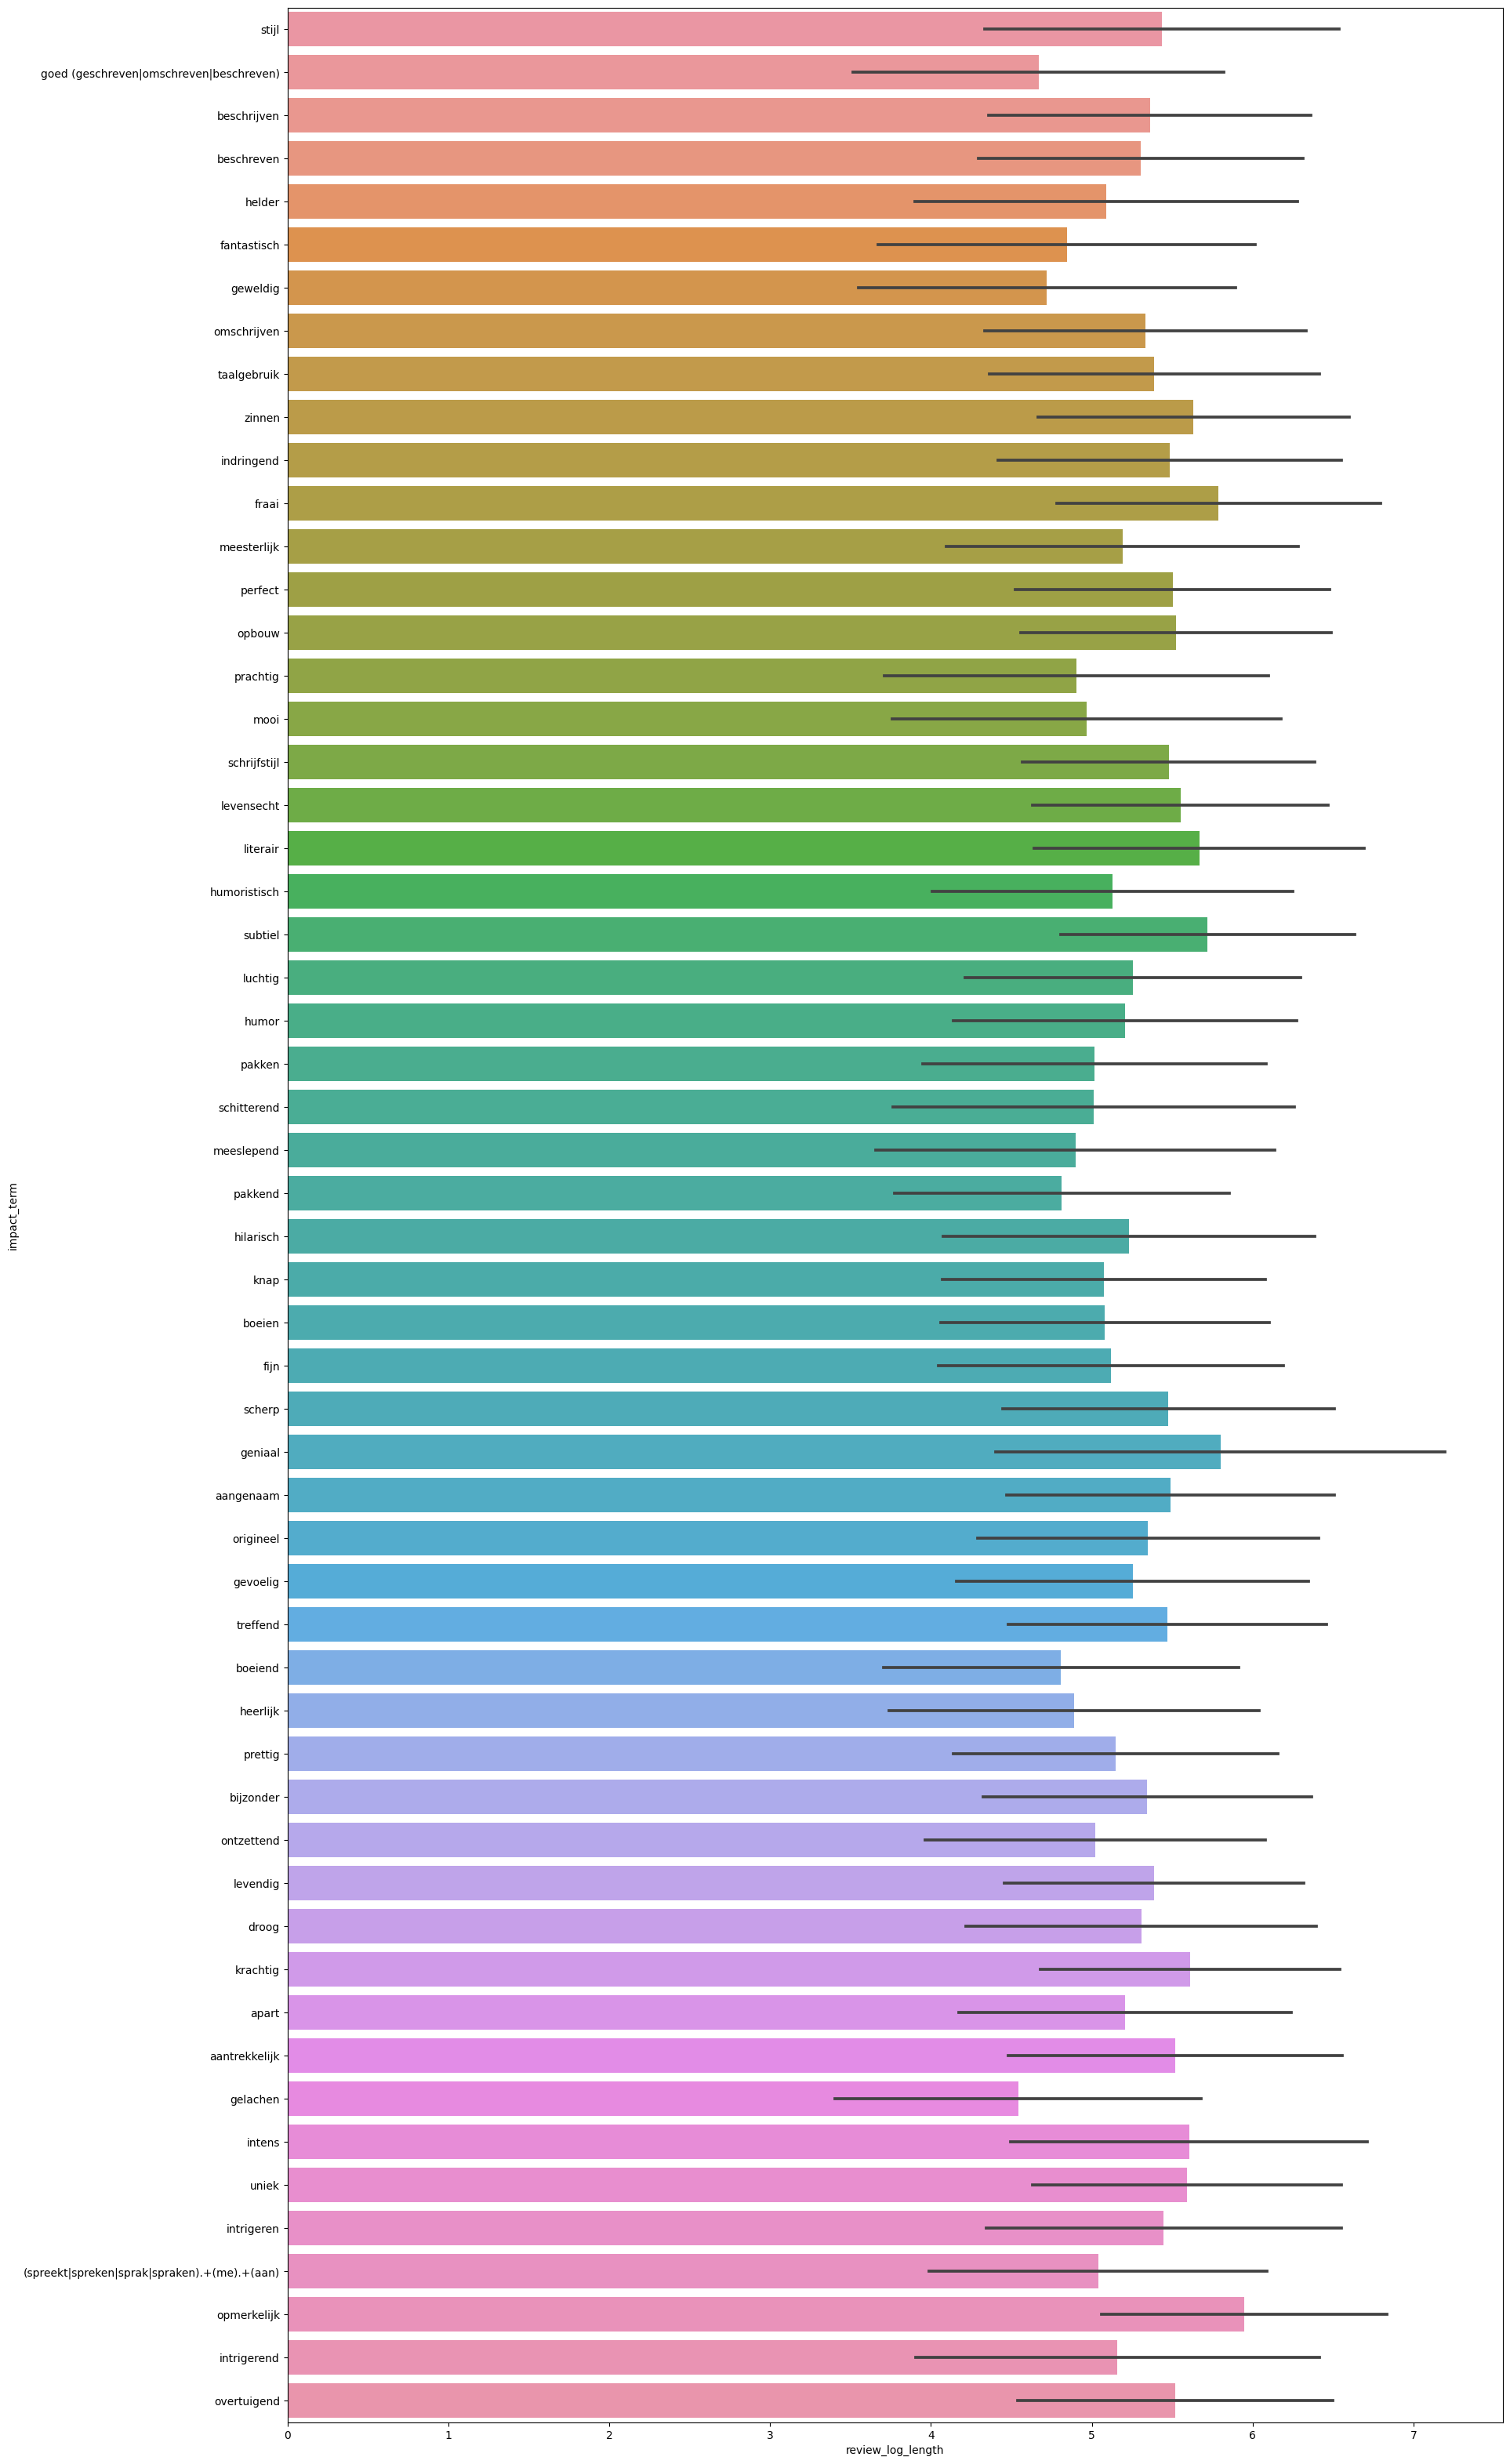

In [200]:
ax = sns.barplot(data=temp[temp['impact_type'] == 'stylistic'], y='impact_term', x='review_log_length', errorbar='sd')

ax.figure.set_size_inches(20, 40)
#impact_length_dist.loc['stylistic'].reset_index()
